# Clustering Crypto

In [273]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Fetching Cryptocurrency Data

In [274]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"
returns =  requests.get(url).json()

In [275]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
df = pd.DataFrame(returns)
df.head()


,Response,Message,Data,BaseImageUrl,BaseLinkUrl,RateLimit,HasWarning,Type
$ANRX,Success,Coin list succesfully returned!,"{'Id': '938161', 'Url': '/coins/anrx/overview'...",https://www.cryptocompare.com,https://www.cryptocompare.com,NaN,False,100
$BASED,Success,Coin list succesfully returned!,"{'Id': '936356', 'Url': '/coins/based/overview...",https://www.cryptocompare.com,https://www.cryptocompare.com,NaN,False,100
$ROPE,Success,Coin list succesfully returned!,"{'Id': '936846', 'Url': '/coins/rope/overview'...",https://www.cryptocompare.com,https://www.cryptocompare.com,NaN,False,100
$TRDL,Success,Coin list succesfully returned!,"{'Id': '938972', 'Url': '/coins/trdl/overview'...",https://www.cryptocompare.com,https://www.cryptocompare.com,NaN,False,100
007,Success,Coin list succesfully returned!,"{'Id': '5294', 'Url': '/coins/007/overview', '...",https://www.cryptocompare.com,https://www.cryptocompare.com,NaN,False,100


In [276]:
# Alternatively, use the provided csv file:
file_path = "Resources/crypto_data.csv"

#Create a DataFrame
file = pd.read_csv(file_path, index_col = 'Unnamed: 0')
file.head()


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [277]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
file_processed = file[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]
file_processed.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [278]:
# Keep only cryptocurrencies that are trading

file_clean = file_processed[file_processed.IsTrading != False]
file_clean.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [279]:
# Keep only cryptocurrencies with a working algorithm
df = file_clean[file_clean.Algorithm != "N/A"]
df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [280]:
# Remove the 'IsTrading' column

df1 = df.drop(columns = ['IsTrading'])
df1.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [281]:
# Remove rows with at least 1 null value

df2 = df1.dropna(axis=0)
df2.head()

for column in df2.columns:
    print(f"Column {column} has {df2[column].isnull().sum()} null values")

Column CoinName has 0 null values
Column Algorithm has 0 null values
Column ProofType has 0 null values
Column TotalCoinsMined has 0 null values
Column TotalCoinSupply has 0 null values


In [282]:
# Remove rows with cryptocurrencies having no coins mined

df3 = df2[df2.TotalCoinsMined != 0]
df3.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0


In [283]:
# Drop rows where there are 'N/A' text values

df3[df3.ProofType.str.contains('N/A')]


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply


In [284]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df 

crypto = pd.DataFrame(df3['CoinName'], index = df3.index)
crypto.head()

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [285]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm

df4 = df3.drop(columns='CoinName')
df4.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [286]:
# Create dummy variables for text features

dummy = pd.get_dummies(df4, columns = ['ProofType', 'Algorithm'])


In [287]:
# Standardize data

file_scaled = StandardScaler().fit_transform(dummy)
#print(file_scaled[0:5])

df_file_scaled = pd.DataFrame(data=file_scaled)
#df_file_scaled.head()

### Reducing Dimensions Using PCA

In [288]:
# Use PCA to reduce dimensions to 3 principal components

# Initialize PCA model
pca = PCA(n_components=3)

file_pca = pca.fit_transform(file_scaled)


In [289]:
# Create a DataFrame with the principal components data

df_file_pca = pd.DataFrame(
    data=file_pca, columns=["PC1", "PC2", "PC3"], index = crypto.index
)
df_file_pca.head()


,PC1,PC2,PC3
42,-0.344277,1.021964,-0.568410
404,-0.327609,1.021957,-0.568837
1337,2.308409,1.586653,-0.753696
BTC,-0.141991,-1.326156,0.180205
ETH,-0.146387,-2.017692,0.417152


### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [290]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_file_pca)
    inertia.append(km.inertia_)


# Create the Elbow Curve using hvPlot
elbow_data = {"k":k, "inertia": inertia}
df_elbow_data = pd.DataFrame(elbow_data)
df_elbow_data.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)


C:\Users\chimd\Anaconda3\envs\pyvizenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [291]:
# Initialize the K-Means model
model = KMeans(n_clusters=4,random_state=0)

# Fit the model
model.fit(df_file_pca)

# Predict clusters
predictions = model.predict(df_file_pca)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([df4, df_file_pca], axis=1, sort=False)
clustered_df["CoinName"] = crypto.CoinName
clustered_df['Cluster Class'] = model.labels_
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Cluster Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.344277,1.021964,-0.568410,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.327609,1.021957,-0.568837,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.308409,1.586653,-0.753696,EliteCoin,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.141991,-1.326156,0.180205,Bitcoin,3
ETH,Ethash,PoW,1.076842e+08,0,-0.146387,-2.017692,0.417152,Ethereum,3


### Visualizing Results

#### 3D-Scatter with Clusters

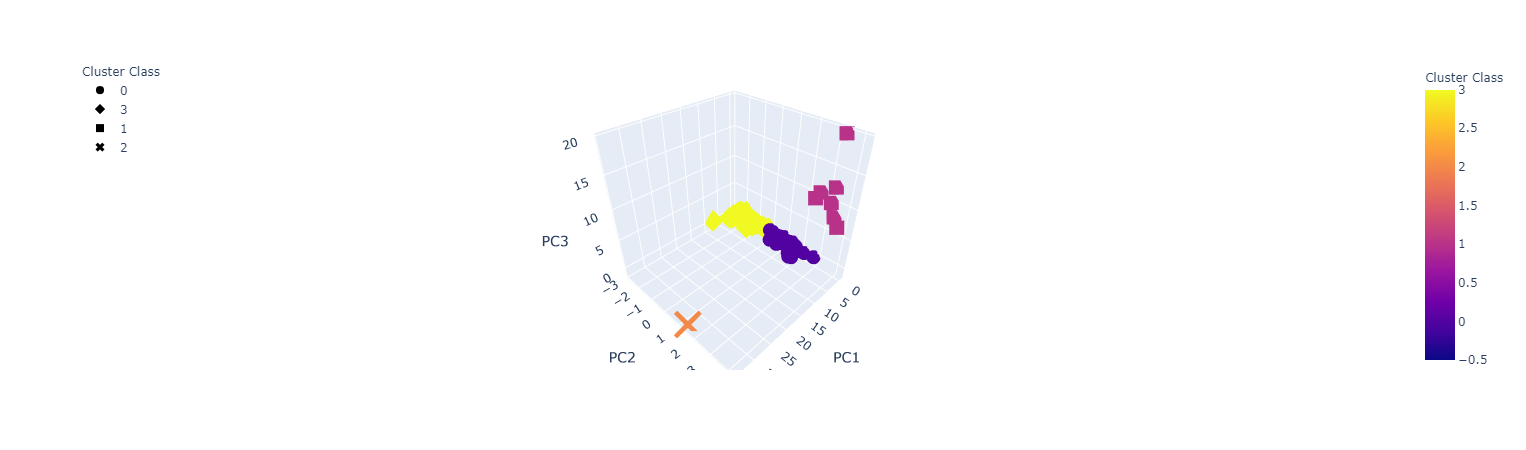

In [292]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Cluster Class",
    symbol="Cluster Class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


#### Table of Tradable Cryptocurrencies

In [293]:
# Table with tradable cryptos

tradable_crypto =  clustered_df.hvplot.table(columns = ['CoinName','Algorithm','ProofType','TotalCoinsMined','TotalCoinSupply', 'Cluster Class'], sortable=True, selectable=True)

tradable_crypto

:Table   [CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,Cluster Class]

In [294]:
# Print the total number of tradable cryptocurrencies
print(tradable_crypto)

:Table   [CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,Cluster Class]


#### Scatter Plot with Tradable Cryptocurrencies

In [295]:
# Scale data to create the scatter plot

scaler = MinMaxScaler()

info = pd.DataFrame(clustered_df[['TotalCoinsMined','TotalCoinSupply']])
info
scaler.fit(info)

#crypto = pd.DataFrame(df3['CoinName'], index = df3.index)
#crypto.head()

# Scaling the training data
infox = scaler.transform(info)
clustered_df[['TotalCoinsMined','TotalCoinSupply']] = infox
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Cluster Class
42,Scrypt,PoW/PoS,0.005942,4.200000e-11,-0.344277,1.021964,-0.568410,42 Coin,0
404,Scrypt,PoW/PoS,0.007002,5.320000e-04,-0.327609,1.021957,-0.568837,404Coin,0
1337,X13,PoW/PoS,0.035342,3.141593e-01,2.308409,1.586653,-0.753696,EliteCoin,0
BTC,SHA-256,PoW,0.005960,2.100000e-05,-0.141991,-1.326156,0.180205,Bitcoin,3
ETH,Ethash,PoW,0.006050,0.000000e+00,-0.146387,-2.017692,0.417152,Ethereum,3


In [296]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"


clustered_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", hover_cols=["CoinName"], color='brown')

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)